In [3]:
import sys
sys.path.append('/home/onizhuk/codes_development/pyCCE')
import pycce as pc
import numpy as np
import matplotlib.pyplot as plt
import ase
import ase.build
import ase.io

import scipy.optimize
sys.path.append('/home/onizhuk/codes_development/useful_scripts')
from dmscripts import *


# Examples of using pyCCE code

## NV Center in diamond

In [100]:
np.random.seed(231)
# From ASE builder
ase_diamond = ase.build.bulk('C', 'diamond', cubic=True)
# Generate NSpinCell
diamond = pc.bath.NSpinCell.from_ase_Atoms(ase_diamond)
diamond.add_isotopes(('13C', 0.011))

v_coord = np.array([0., 0., 0.])
n_coord = np.array([0.25, 0.25, 0.25])

diamond.zdir = (1, 1, 1)
diamond_bath = diamond.gen_supercell(200, remove=[('C', v_coord), ('C', n_coord)], add=('14N', n_coord))

Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])


In [104]:
r_bath = 40
r_dipole = 8
order = 2

N = 1
timespace = np.linspace(0, 2, 101)
B = np.array([0, 0, 200])

L = 0
for i in range(100):
    diamond_bath = diamond.gen_supercell(200, remove=[('C', v_coord), ('C', n_coord)], add=('14N', n_coord))
    calc = pc.Simulator(1, v_coord, [0,0,1], [0,1,0], bath_spins=diamond_bath, 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    L += calc.compute_coherence(timespace, B, N)
L /= (i+1)

Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.5
Number of disjointed clusters is 27
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.9
Number of disjointed clusters is 24
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.7
Number of disjointed clusters is 37
I see 1 removals
Removing: 
 [('13C', [0., 0., 0.])]
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.7
Number of disjointed clusters is 25
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.4
Number of disjointed clusters is 34
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.7
Number of disjointed clusters is 28
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 3.4
Number of disjointed clusters is 26
Adding: 
 ('14N', [-0.     ,  0.     ,  1.54586])
Average number of neighbours is 4.1
Number 

# Conventional CCE

In [102]:
L = calc.compute_coherence(timespace, B, N)

[0.88116 1.9879 ]


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]


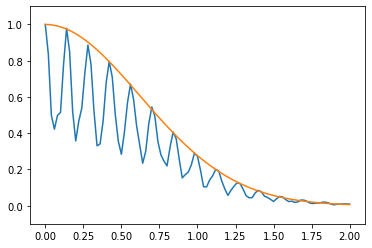

In [111]:
import scipy.optimize
plt.plot(timespace[L.real <= 1.1], L[L.real <= 1.1])
plt.ylim(-0.1, 1.1)
l, p = newt2_fit(timespace[L.real <= 1.1], L.real[L.real <= 1.1], r=6)
plt.plot(timespace[L.real <= 1.1], l(timespace[L.real <= 1.1], *p))
print(p)

# Different materials

In [4]:
si_ase = ase.io.read('si.cif')
si = pc.bath.NSpinCell.from_ase_Atoms(si_ase)
si.add_isotopes(('29Si', 0.047))
si.zdir = [1, 1, 1]
vc_uc = [0.5, 0.5, 0.5]
vc = si.to_cartesian(vc_uc)
atoms = si.gen_supercell(200, remove=('Si', vc_uc))

In [88]:
volume = si.cell[:, 0].dot(np.cross(si.cell[:, 1], si.cell[:, 2]))
print(volume)
print(np.linalg.det(si.cell))
print(si.atoms)
print(si.cell)
print(si.atoms['Si'].__len__()/volume)

163.55317139465933
163.55317139465927
{'Si': [array([0.25, 0.75, 0.25]), array([0. , 0. , 0.5]), array([0.25, 0.25, 0.75]), array([0. , 0.5, 0. ]), array([0.75, 0.75, 0.75]), array([0.5, 0. , 0. ]), array([0.75, 0.25, 0.25]), array([0.5, 0.5, 0.5])]}
[[5.46873 0.      0.     ]
 [0.      5.46873 0.     ]
 [0.      0.      5.46873]]
0.048913756497547395


In [8]:
r_bath = 60
r_dipole = 12
order = 2

N = 1
timespace = np.linspace(0, 2, 101)
B = np.array([0, 0, 5000])
Lsi = 0
for i in range(1):
    calc = pc.Simulator(1/2, vc, [1,0], [0,1], bath_spins=atoms, 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    Lsi += calc.compute_coherence(timespace, B, N, as_delay=False)
Lsi /= i + 1

Average number of neighbours is 15.2
Number of disjointed clusters is 1


/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


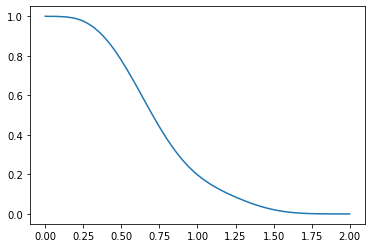

In [7]:
plt.plot(timespace, Lsi)

In [5]:
llist = []
B = np.array([5000, 0, 0])

for r_dipole in (8, 10):
    calc = pc.Simulator(1/2, vc, [1,0], [0, 1], bath_spins=atoms, 
                        r_bath=r_bath, r_dipole=r_dipole, order=order)
    llist.append(calc.compute_coherence(timespace, B, N, as_delay=False))

NameError: name 'r_bath' is not defined

[0.92785 2.56294]


/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]
/home/onizhuk/codes_development/useful_scripts/dmscripts.py:179: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / t2) ** n) * y[0]


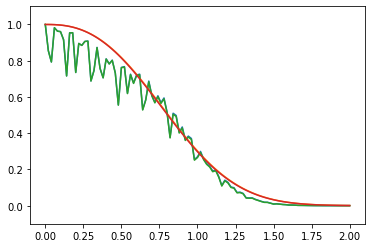

In [157]:
import scipy.optimize
for l in llist:
    l = l.real
    c = l <= 1.1
    plt.plot(timespace[c], l[c])
    plt.ylim(-0.1, 1.1)
    f, p = newt2_fit(timespace[c], l[c], r=6)
    plt.plot(timespace[c], f(timespace[c], *p))
print(p)

In [80]:
sic_ase = ase.io.read('4h-sic_conventional.cif')
sic = pc.bath.NSpinCell.from_ase_Atoms(sic_ase)
sic.add_isotopes(('29Si', 1), ('13C', 1))
atoms = si.gen_supercell(10)

In [90]:
volume = np.linalg.det(sic.cell.T)
print(sic.cell)
print(sic.atoms['Si'].__len__()/volume)

83.96315758938724

[[ 3.09401 -1.547    0.     ]
 [ 0.       2.67949  0.     ]
 [ 0.       0.      10.12782]]
0.04763994250384875


In [64]:
np.set_printoptions(precision=5, suppress=True)
atoms

BathArray([('29Si', [-1.547  , -0.89316,  4.43445], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [ 0.     , -1.78633,  9.49836], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [-1.547  , -2.67949,  1.90299], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [-1.547  , -2.67949,  6.96689], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [-3.09401,  1.78633,  4.43445], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [-1.547  ,  0.89316,  9.49836], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('29Si', [-3.09401,  0.     ,  1.90299], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]], [[0., 0., 0.], [0., 0., 0.], [0., 0., 0.]]),
           ('